```mermaid
graph TD
a(三元阵列数据)--线性预测虚拟阵元在三阵元间补阵元, 减小阵元间距--> b(阵元间距小于半波长/宽带互谱最大距离的N元阵列数据)
b--stft-->c(时频图)--相位信息-->d(有注意力的时频相位图)-->h(lstm)-->i(距离, 角度)
c--幅度信息-->f(时频幅度图)--给出时频注意力, 聚焦有脉冲的部分-->d
f--常规波束形成-->短时空间谱-->i
```

宽带信号互谱法要求$d\le \frac{c}{2B}$, 当带宽B=500Hz, d_max = 1.5m

加有方位的噪声源允许学习出空间特性

由于注意力应当与空间, 频率, 相位相关, 因此必然要学习参数, SimAm这样的无参数注意力层肯定不行

In [48]:
import os

os.environ['WANDB_NOTEBOOK_NAME'] = os.path.abspath('.') + '/wideband_cpsd_cnn.ipynb'
import numpy as np
import torch
import torchmetrics
import wandb
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchkeras import KerasModel
from torchmetrics import Accuracy
from torchkeras import kerascallbacks

import Datasets
import feature_modules

## 数据准备

### 数据处理

先分批将每个样本中数据按时间窗转为频相图, 作为特征

In [49]:
c = 1500
fc = 42500
fs_factor = 8
fs = fs_factor * fc
d = 0.5
K = 1.0
SNR = 'mixed'
r = [800, 1000]
dist_max = d * (K + 1)
maxlag = int(np.ceil(dist_max / c * fs))  # 当前采样频率下最大滞后量
sample_interval = 1

dataset_path = f'/root/autodl-tmp/dataset/fc_{fc}-fs_factor_{fs_factor}-d_{d}-K_{K}-SNR_{SNR}-r_{r[0]}_{r[1]}'
train_path = f'{dataset_path}/train'
val_path = f'{dataset_path}/val'
feature = 'cpsd_phase'

batch_size = 128

def map(from_min, from_max, to_min, to_max):
    interpolator = interp1d([from_min, from_max], [to_min, to_max])
    return lambda x: interpolator(max(from_min, min(x, from_max)))

In [50]:
def process_data(feature):
    spectrogram_layer = feature_modules.Spectrogram(fs, 8192).to('cuda')
    cpsd_phase_layer = feature_modules.CPSD_Phase_Spectrogram().to('cuda')

    for folder_path in [train_path, val_path]:
        if not os.path.exists(f'{folder_path}_{feature}'):
            os.makedirs(f'{folder_path}_{feature}')
        batch_size = 400
        dl = DataLoader(Datasets.Array_Data_DataSet(folder_path), batch_size=batch_size, shuffle=False, num_workers=32, drop_last=False)
        print('batch ', end='')
        for batch, (data_segments_batch, fs_batch, r_n_batch, angle_n_batch, filename_batch) in enumerate(dl):
            spectrogram = spectrogram_layer(data_segments_batch.to('cuda'))
            if feature == 'cpsd_phase':
                phase_batch = cpsd_phase_layer(spectrogram).cpu().detach().numpy().astype(np.float32)  # shape: (batch_size, 3, freq_limited, time)
            elif feature == 'phase':
                phase_batch = torch.angle(spectrogram).cpu().detach().numpy().astype(np.float32)  # shape: (batch_size, 3, freq_limited, time)
            else:
                raise ValueError('feature not found')
            r_n_batch = r_n_batch.numpy().astype(np.float32)  # shape: (batch_size, seconds)
            angle_n_batch = angle_n_batch.numpy().astype(np.float32)  # shape: (batch_size, seconds)
            for i, filename in enumerate(filename_batch):
                if os.path.exists(f'{folder_path}_{feature}/{filename[:-4]}.npz'):
                    continue
                np.savez(f'{folder_path}_{feature}/{filename[:-4]}.npz', data=phase_batch[i], label=np.array((r_n_batch[i], angle_n_batch[i])))
            print(f'{batch},', end='')
            batch += 1
        print(f'\n{folder_path} done')

# process_data('cpsd_phase')

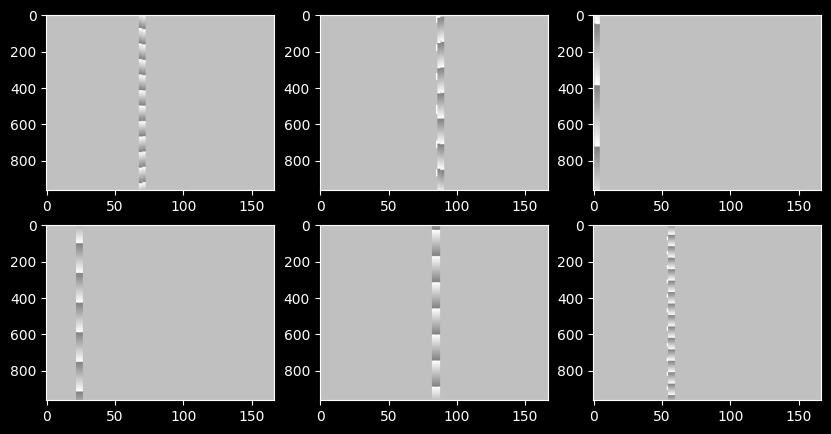

In [51]:
# %matplotlib widget
class FeaturesDataSet(Dataset):
    def __init__(self, folder_path):
        # folder_path下所有文件的列表
        self.filepaths = [f'{folder_path}/{filename}' for filename in os.listdir(folder_path)]

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        # tensors = torch.load(self.filepaths[idx])
        arrays = np.load(self.filepaths[idx])
        # data = arrays['data'][0]  # shape: (3, f_len, t_len)
        data = arrays['data'][0] # shape: (3, f_len, t_len)
        data = (data + np.pi) / (2 * np.pi)  # 归一化到[0, 1]
        # data = data[:, ::10, :]
        # data = np.diff(data, axis=1)
        label = arrays['label'][:, 0]
        theta = np.deg2rad(label[1, 0])
        label = np.array((
                np.cos(theta),
                np.sin(theta),
                # map(500, 1000, 0, 1)(label[0, 0]),
            )).astype(np.float32).reshape(-1)
        # label = np.append(label / r, map(max(100, min(r, 1000)))).astype(np.float32)
        # label = torch.tensor(np.rad2deg(np.arctan2(label[1], label[0]))) - 15
        # label = nn.functional.one_hot(label.to(torch.int64), num_classes=151).float()
        return data, label

ds_train = FeaturesDataSet(f'{train_path}_{feature}')
ds_val = FeaturesDataSet(f'{val_path}_{feature}')

from matplotlib.colors import Normalize
norm = Normalize(vmin=-1, vmax=1)
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(ds_train[i][0][i], aspect='auto', cmap='gray', norm=norm)
    plt.subplot(2, 3, i+4)
    plt.imshow(ds_val[i][0][i], aspect='auto', cmap='gray', norm=norm)

In [52]:
# 取样时有打乱
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=16, drop_last=False)
dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=True, num_workers=16, drop_last=False)

## 模型定义

In [53]:
from torchvision.models import resnet18, ResNet18_Weights

class Predictor(nn.Module):
    def __init__(self):
        super().__init__()
        weights = ResNet18_Weights.DEFAULT
        self.transforms = weights.transforms(antialias=True)
        self.resnet18 = resnet18(weights=weights)
        self.resnet18.fc = torch.nn.Linear(in_features=self.resnet18.fc.in_features, out_features=2)
        # TODO: Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.transforms(x)
        x = self.resnet18(x)
        x = torch.tanh(x)
        return x

## 模型训练

<<<<<< ⚡️ cuda is used >>>>>>


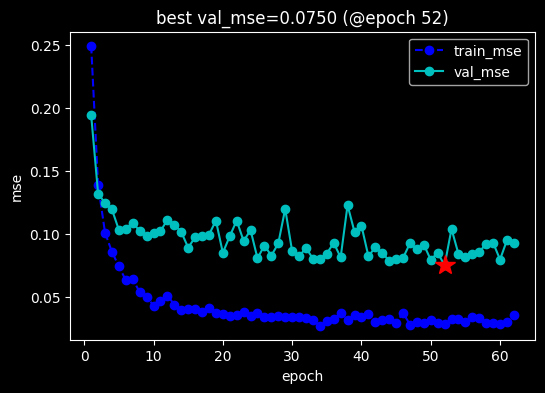

<<<<<< val_mse without improvement in 10 epoch,early stopping >>>>>> 



,epoch,train_loss,train_mse,lr,val_loss,val_mse
0,1,0.247889,0.249243,0.03,0.194182,0.194162
1,2,0.138238,0.138756,0.03,0.132118,0.131954
2,3,0.100788,0.100937,0.03,0.124133,0.124446
3,4,0.085782,0.085611,0.03,0.119418,0.119289
4,5,0.074364,0.074198,0.03,0.102966,0.103040
...,...,...,...,...,...,...
57,58,0.029052,0.029283,0.03,0.092070,0.092285
58,59,0.029467,0.029486,0.03,0.092722,0.092938
59,60,0.028356,0.028162,0.03,0.079447,0.079537
60,61,0.029329,0.029652,0.03,0.095231,0.094917


In [54]:
from torchkeras.kerascallbacks import WandbCallback
from argparse import Namespace

def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.normal_(m.weight)
        m.bias.data.fill_(0.0)

net = Predictor()
# net.apply(init_weights)  # 初始化权重为全零

lr = 3e-2
optimizer=optim.SGD(net.parameters(), lr=lr)
# optimizer=optim.Adam(net.parameters(), lr=lr)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

model = KerasModel(
    net,
    # loss_fn=loss_with_regulation,
    # loss_fn=nn.L1Loss(),
    loss_fn=nn.MSELoss(),
    metrics_dict={
        # 'L1': torchmetrics.MeanAbsoluteError(),
        'mse': torchmetrics.MeanSquaredError(),
    },
    optimizer=optimizer,
    # lr_scheduler=lr_scheduler
)

model.fit(
    dl_train,
    dl_val,
    epochs=50,
    ckpt_path='exp/checkpoint',
    patience=5,
    monitor='val_mse',
    mode='min',
    plot=False,
    quiet=True,
    callbacks=[
        kerascallbacks.VisProgress(),
        kerascallbacks.VisMetric(save_path='exp/history.jpg'),
        # WandbCallback(project='wideband_cpsd_cnn', save_code=True, save_ckpt=True,
        #     config=Namespace(
        #         batch_size=batch_size,
        #         lr=lr,
        # ))
    ]
)

## 模型分析

### 特征图

In [28]:
# take out all meaningful conv2 layers in the net

model_weights =[]
conv_layers = []

model_children = list(net.resnet18.children())
counter = 0

for child in model_children:
    if type(child) == nn.Conv2d:
        counter+=1
        model_weights.append(child.weight)
        conv_layers.append(child)
    elif type(child) == nn.Sequential:
        for gChild in child:
            for ggChild in gChild.children():
                if type(ggChild) == nn.Conv2d:
                    counter+=1
                    model_weights.append(ggChild.weight)
                    conv_layers.append(ggChild)
                elif type(ggChild) == nn.Sequential:
                    if type(ggChild[1]) == SimAM:
                        counter += 1
                        model_weights.append(ggChild[0].weight)
                        conv_layers.append(ggChild[0])

print(counter)

17


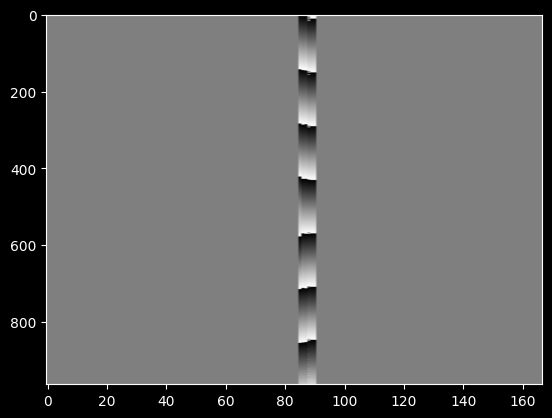

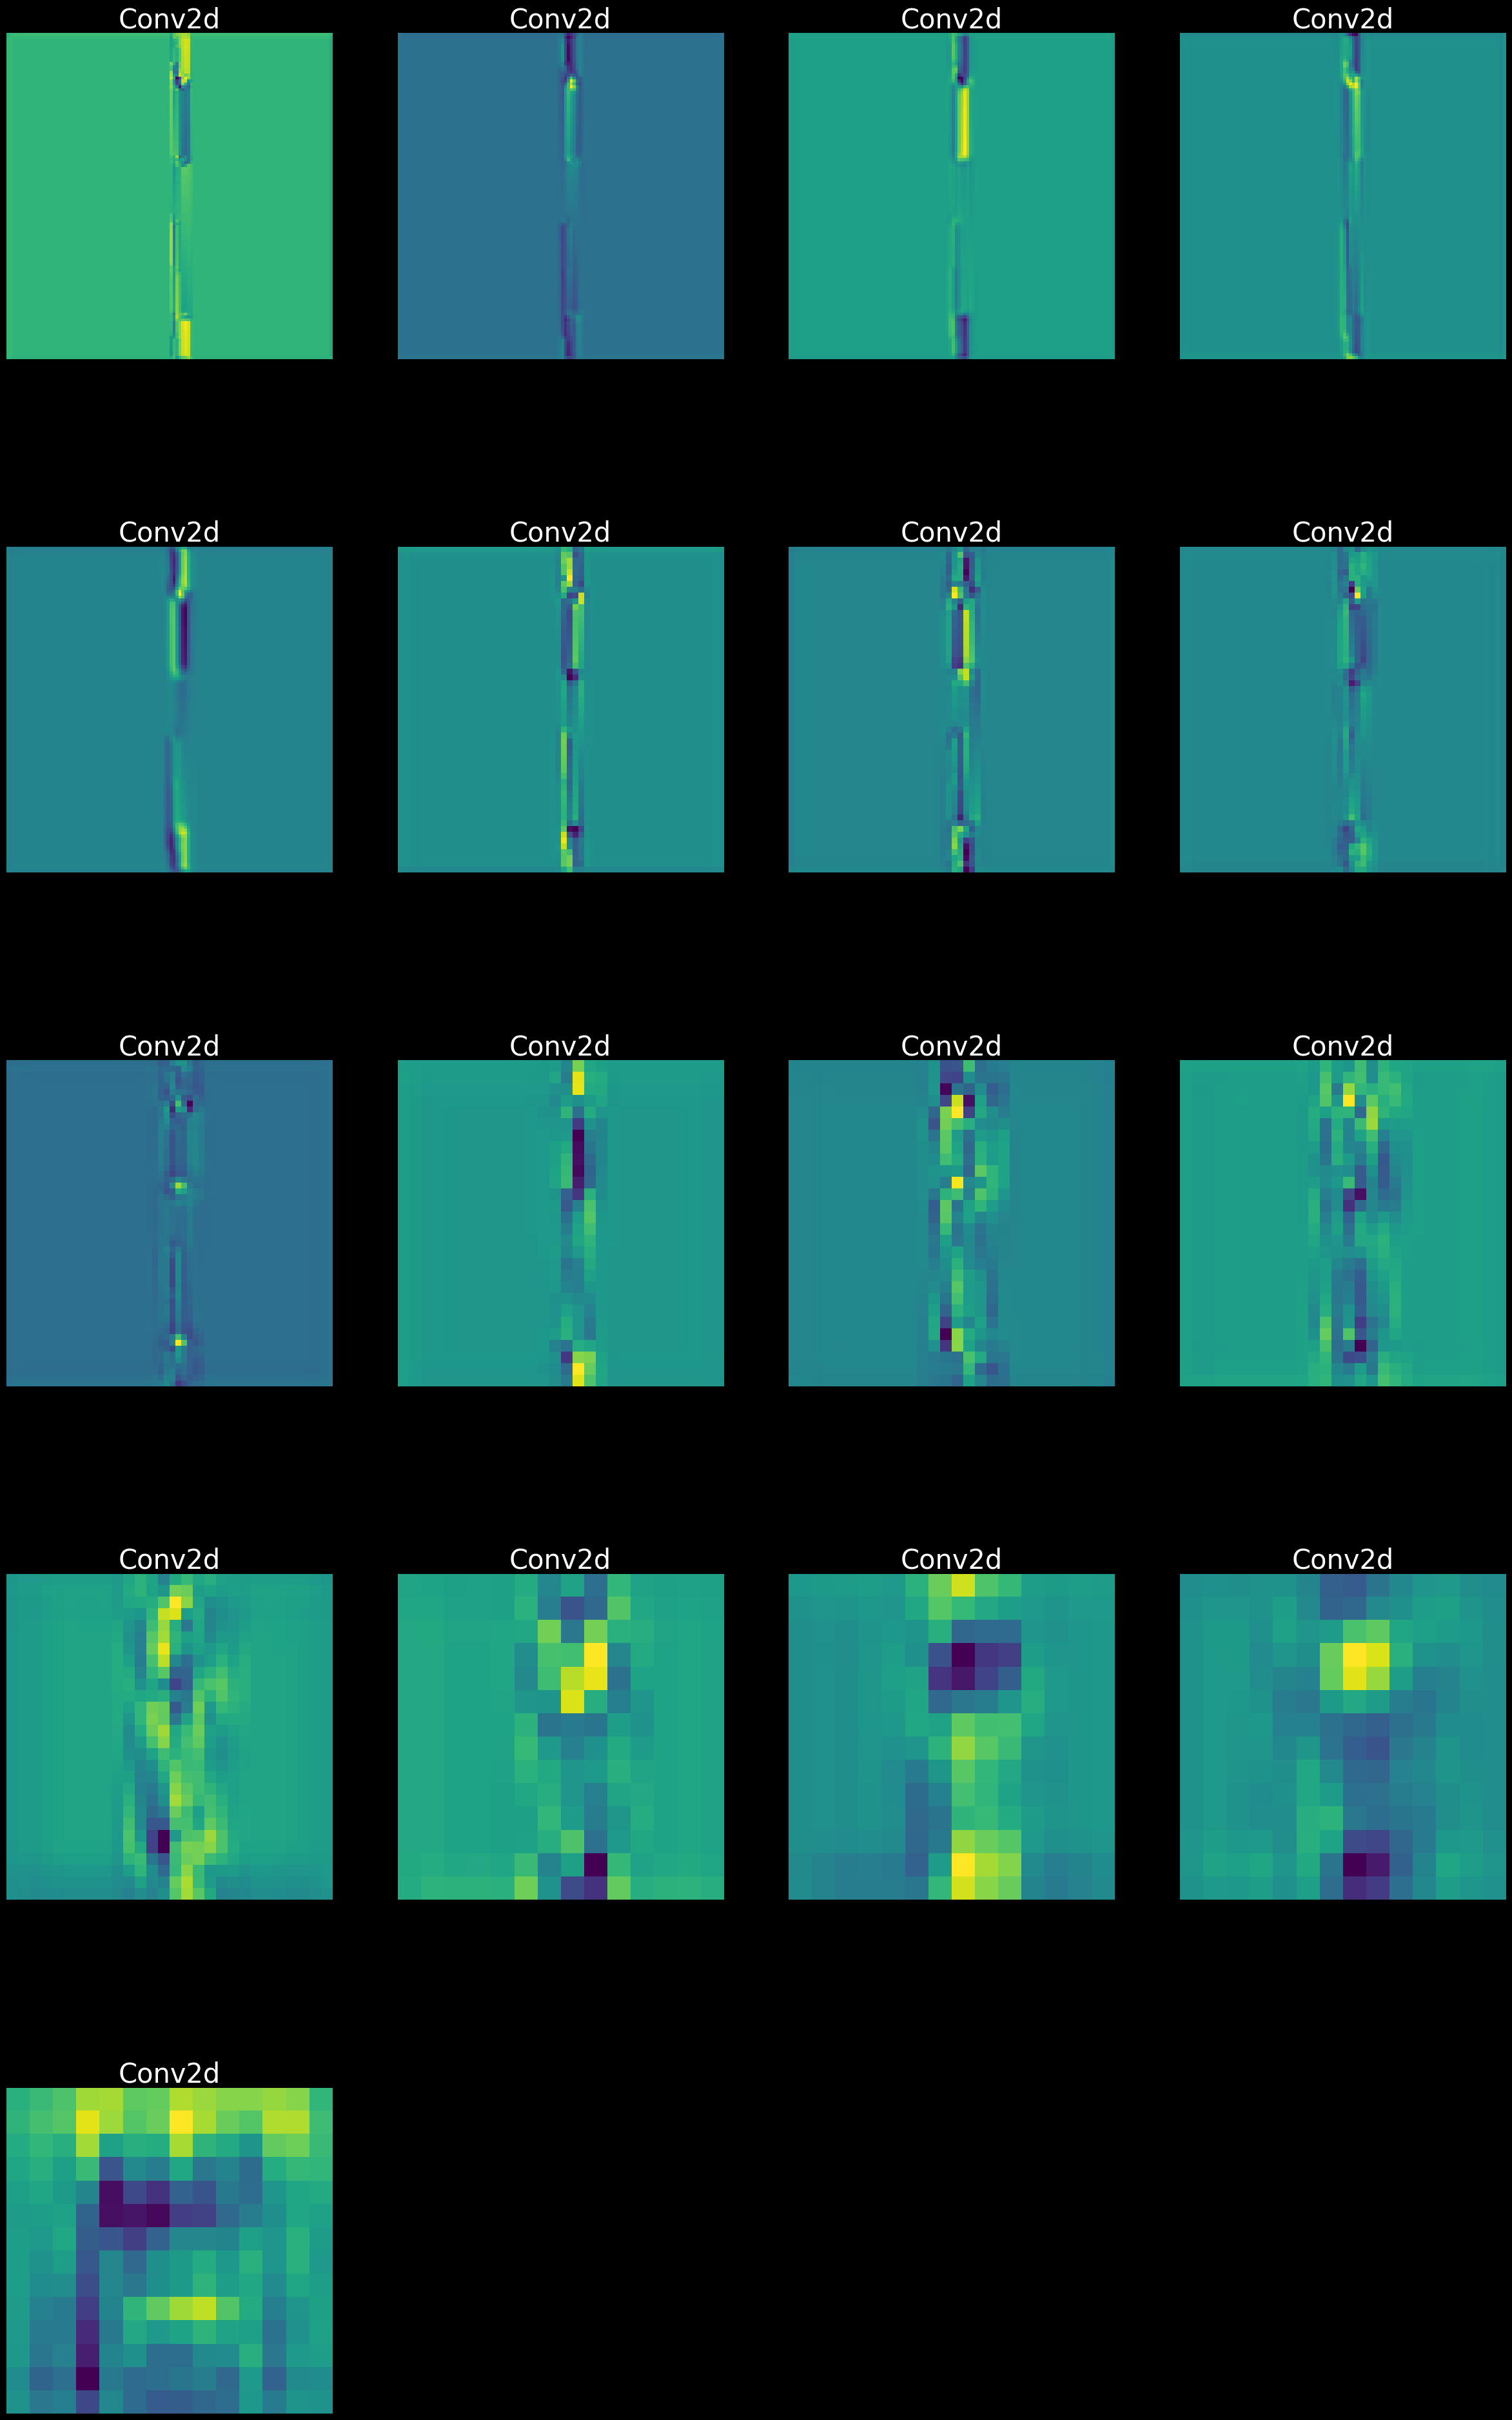

In [46]:
# feed a input and obtain all feature maps

input = ds_train[1][0]
plt.imshow(input[0], aspect='auto', cmap='gray')
input = net.transforms(torch.tensor(input)).cuda()
outputs = []
names = []
for layer in conv_layers:
    input = layer(input)
    outputs.append(input)
    names.append(str(layer))
# for feature_map in outputs:
#     print(feature_map.shape)
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
# for fm in processed:
#     print(fm.shape)

fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)

## 模型评估

### 标签为$(cos(\theta), sin(\theta))$

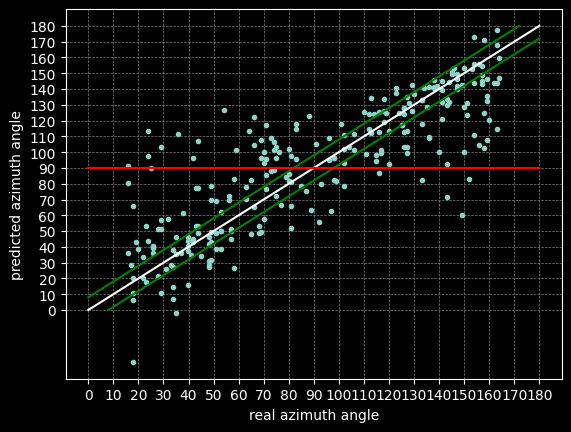

In [13]:
device = torch.device('cuda')

checkpoint_path = "./exp/checkpoint"
checkpoint = torch.load(checkpoint_path)
net = Predictor()
net.load_state_dict(checkpoint)
net.eval()
net.to(device)

dl_val = DataLoader(ds_val, batch_size=250, shuffle=False, num_workers=16, drop_last=False)
dl_iter = iter(dl_val)
data, label = next(dl_iter)
data, label = next(dl_iter)
data = data.to(device)
predicted = net(data).detach().cpu().numpy()
label_angles = np.rad2deg(np.arctan2(label[:, 1], label[:, 0]))
predicted_angles = np.rad2deg(np.arctan2(predicted[:, 1], predicted[:, 0]))
plt.plot(label_angles, predicted_angles, '.')
plt.plot([0, 180], [0, 180], 'white')
plt.plot([0, 172], [8, 180], 'green')
plt.plot([8, 180], [0, 172], 'green')
plt.plot([0, 180], [90, 90], 'red')

plt.xlabel('real azimuth angle')
plt.ylabel('predicted azimuth angle')
plt.xticks(np.arange(0, 190, 10))
plt.yticks(np.arange(0, 190, 10))
plt.grid(True, which='major', color='gray', linestyle='--', linewidth=0.5)

### 标签为$(cos(\theta), sin(\theta), r)$

In [62]:
device = torch.device('cuda')

checkpoint_path = "./exp/checkpoint"
checkpoint = torch.load(checkpoint_path)
net.load_state_dict(checkpoint)
net.eval()
net.to(device)

dl_val = DataLoader(ds_val, batch_size=400, shuffle=False, num_workers=16, drop_last=False)
data, label = next(iter(dl_val))
data = data.to(device)
label = label.numpy()
predicted = net(data).detach().cpu().squeeze(0).numpy()
r_label = np.array([map(0, 1, 500, 1000)(r) for r in label[:, 2]])
theta_label = np.arctan2(label[:, 1], label[:, 0])
r_predicted = np.array([map(0, 1, 500, 1000)(r) for r in predicted[:, 2]])
theta_predicted = np.arctan2(predicted[:, 1], predicted[:, 0])

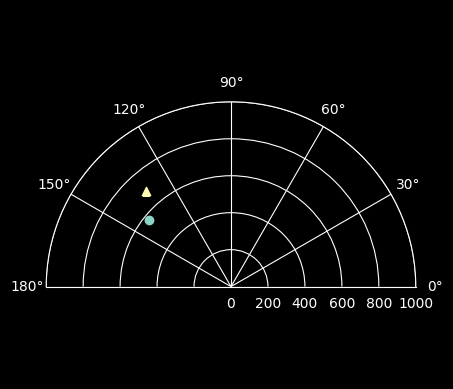

In [94]:
# show prediction of a random sample in the validation set
idx = np.random.randint(0, 400)
plt.figure()
ax = plt.subplot(111, polar=True)
ax.scatter(theta_label[idx], r_label[idx], marker='o')
ax.scatter(theta_predicted[idx], r_predicted[idx], marker='^')
ax.set_xlim(0, np.pi)
ax.set_ylim(top=1000)
plt.show()